## 02: Data Preparation

1. Here we construct our dataset for use in the experiment.

In [1]:
# import required libraries
import sys
sys.path.append('../../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
import random
import libs.utils as utils
import libs.bounding_box as bounding_box
import libs.patch_tools as patch_tools
import libs.data_prep as data_prep
import libs.train_test_split as tts
import libs.importing as importing
import libs.render as render
import libs.stats as stats
import libs.patch_tools as patch_tools
from importlib import reload


# set the random seed for we always get the same results (for now)
random.seed(42)


In [3]:
# GENERATE DATASET ID
exp_id = utils.short_id()
# use same data
exp_id = '4b7ab9e9'
print('ID: {}'.format(exp_id))

ID: 4b7ab9e9


In [4]:
# COPY DATA and SETUP EXPERIMENT
base_dir = '../source_dataset/good_v1'
data_prep.setup_experiment(base_dir, exp_id)

In [5]:
# 2-CLASS PROBLEM : Benign v. Papilloma

# SETUP : GET ALL CONTOURS
roi_df = pd.read_csv(os.path.join(exp_id, 'contours.csv'))
roi_2class = roi_df.copy()

# SELECT : only benign and papilloma labeled contours
#roi_2class = roi_2class[roi_2class.label.isin([1,3,4])].reset_index(drop=True)

# combine all dysplasias and carcinomas
roi_2class.loc[roi_2class['label'] == 4, 'label'] = 3

train2bp_df, test2bp_df, val2bp_df = tts.train_test_validation_split(roi_2class, classes=[1,2,3], samples=2)

# SAVE : save the results
train2bp_df.to_csv(os.path.join(exp_id, 'contours_train.csv'), index=False)
test2bp_df.to_csv(os.path.join(exp_id, 'contours_test.csv'), index=False)
val2bp_df.to_csv(os.path.join(exp_id, 'contours_val.csv'), index=False)

n: 65
distribution: [1 2 3] [21 11 33]
classes: [1 2 3], samples_per_class: 2
train-n: 53
test-n: 6
val-n: 6


In [3]:
# OR IF we've already run this notebook before we can just load the data
train2bp_df = pd.read_csv(os.path.join(exp_id, 'contours_train.csv'))
test2bp_df = pd.read_csv(os.path.join(exp_id, 'contours_test.csv'))
val2bp_df = pd.read_csv(os.path.join(exp_id, 'contours_val.csv'))

In [6]:
# LOG : show all the contours we dumped and those we are using
#       these are logged at: 
#       [dumped] ./exp_id/log/eleminated_contours
#       [kept]   ./exp_id/log/experiment_contours
data_prep.show_contours_for_experiment(exp_id, roi_df, roi_2class)

total contours: 65
eliminated contours: 0
kept contours: 65


Empty DataFrame
Columns: [image_id, id, name, label]
Index: []

In [7]:
# TRAIN : data setup
#       : creates a directory ./exp_id/train/  where all the images and contours for training are stored
#       : creates a directory ./exp_id/train/log/info, where the contours and labels for the training set are stored as images for debugging purposes. 
train_df  = pd.read_csv(os.path.join(exp_id, 'contours_train.csv'))
data_prep.setup_component(exp_id, train_df, 'train')
data_prep.log_component_info(os.path.join(exp_id, 'train'))

In [8]:
# TEST : data setup
#       : creates a directory ./exp_id/test/  where all the images and contours for test data are stored
#       : creates a directory ./exp_id/test/log/info, where the contours and labels for the test set are stored as images for debugging purposes.
test_df = pd.read_csv(os.path.join(exp_id, 'contours_test.csv'))
data_prep.setup_component(exp_id, test_df, 'test')
data_prep.log_component_info(os.path.join(exp_id, 'test'))

In [9]:
# VALIDATION : data setup
#       : creates a directory ./exp_id/val/  where all the images and contours for validation data are stored
#       : creates a directory ./exp_id/val/log/info, where the contours and labels for the validation set are stored as images for debugging purposes.
val_df = pd.read_csv(os.path.join(exp_id, 'contours_val.csv'))
data_prep.setup_component(exp_id, val_df, 'val')
data_prep.log_component_info(os.path.join(exp_id, 'val'))

In [10]:
# GENERATE PATCHES : training data
#                    logs information to ./exp_id/train/log/setup_patches, where it shows patches on the image before and after removal

# threshold : the percentage a patch needs to overlap with the contour polygon in order to not be discarded
# patch_overlap : the shift size, should be a value which generates a factor of 64 for instance 0.5*64 = 32, or 0.25 * 64 = 16, etc.
train_patches_df = data_prep.setup_patches_for(os.path.join(exp_id, 'train'), patch_size = 64, patch_overlap = 0.5, threshold = 0.5)

# inspect the structure of our patches.csv file
display(train_patches_df.head())

# see how many training patches we have 
print('count: {}'.format(len(train_patches_df)))

image_id contour_id  patch_id    patch_name    x    y label_id
0  hgv-44a1f2e3   2dd43905  0ecfbea1  0ecfbea1.jpg  762  674        3
1  hgv-44a1f2e3   2dd43905  db5171bc  db5171bc.jpg  794  674        3
2  hgv-44a1f2e3   2dd43905  addc486c  addc486c.jpg  826  674        3
3  hgv-44a1f2e3   2dd43905  71698f6f  71698f6f.jpg  858  674        3
4  hgv-44a1f2e3   2dd43905  c81e2ff4  c81e2ff4.jpg  890  674        3

count: 3426


In [11]:
# GENERATE PATCHES : test data
#                    logs information to ./exp_id/test/log/setup_patches, where it shows patches on the image before and after removal
test_patches_df = data_prep.setup_patches_for(os.path.join(exp_id, 'test'), patch_size = 64, patch_overlap = 0.5, threshold = 0.5)

display(test_patches_df.head())
print('count: {}'.format(len(test_patches_df)))

image_id contour_id  patch_id    patch_name     x    y label_id
0  hgv-2cdb69f6   935831de  75d63301  75d63301.jpg  1115  130        2
1  hgv-2cdb69f6   935831de  08269546  08269546.jpg  1147  130        2
2  hgv-2cdb69f6   935831de  4b678ab7  4b678ab7.jpg  1179  130        2
3  hgv-2cdb69f6   935831de  9544a632  9544a632.jpg  1083  162        2
4  hgv-2cdb69f6   935831de  fd35322f  fd35322f.jpg  1115  162        2

count: 301


In [12]:
# GENERATE PATCHES : validation data
#                    logs information to ./exp_id/val/log/setup_patches, where it shows patches on the image before and after removal
val_patches_df = data_prep.setup_patches_for(os.path.join(exp_id, 'val'), patch_size = 64, patch_overlap = 0.5, threshold = 0.5)

display(val_patches_df.head())
print('count: {}'.format(len(val_patches_df)))

image_id contour_id  patch_id    patch_name    x    y label_id
0  hgv-2d4a6a46   76f536d8  080e67a6  080e67a6.jpg  910  712        1
1  hgv-2d4a6a46   76f536d8  d99bb5b6  d99bb5b6.jpg  942  712        1
2  hgv-2d4a6a46   76f536d8  f952b250  f952b250.jpg  814  744        1
3  hgv-2d4a6a46   76f536d8  7da1aa23  7da1aa23.jpg  846  744        1
4  hgv-2d4a6a46   76f536d8  73df3068  73df3068.jpg  878  744        1

count: 271


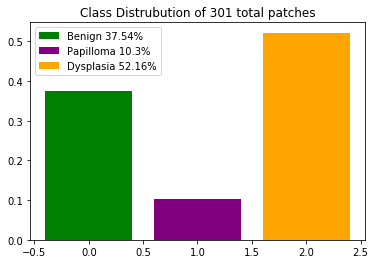

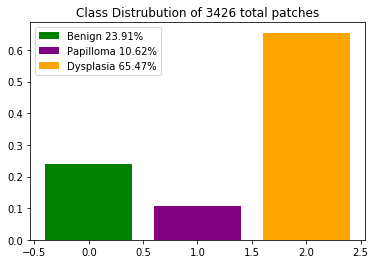

In [14]:
# BEFORE FILTERING PATCHES LOOK AT PATCH DISTRIBUTION
stats.plot_label_distribution(val_patches_df, labels=[1,2,3], label_key='label_id')
stats.plot_label_distribution(test_patches_df, labels=[1,2,3], label_key='label_id')
stats.plot_label_distribution(train_patches_df, labels=[1,2,3], label_key='label_id')

In [15]:
# FILTER PATCHES : some patches have way too much light or are just bad quality
#                  here we filter out patches which are so specular they contain very little information
#                  see: filtered patches are drawn onto the image at : ./exp_id/{train,test,val}/log/filter_highlight_patches - useful for debugging

train_dir = os.path.join(exp_id, 'train')
test_dir = os.path.join(exp_id, 'test')
val_dir = os.path.join(exp_id, 'val')

data_prep.filter_highlight_patches_for(train_dir, patch_size = 64, threshold=0.5)
data_prep.filter_highlight_patches_for(test_dir, patch_size = 64, threshold=0.5)
data_prep.filter_highlight_patches_for(val_dir, patch_size = 64, threshold=0.5)


bad patches: 11
before: 3426
cleaned: 3415
bad patches: 0
before: 301
cleaned: 301
bad patches: 0
before: 271
cleaned: 271


image_id contour_id  patch_id    patch_name     x    y  label_id
0    hgv-2d4a6a46   76f536d8  080e67a6  080e67a6.jpg   910  712         1
1    hgv-2d4a6a46   76f536d8  d99bb5b6  d99bb5b6.jpg   942  712         1
2    hgv-2d4a6a46   76f536d8  f952b250  f952b250.jpg   814  744         1
3    hgv-2d4a6a46   76f536d8  7da1aa23  7da1aa23.jpg   846  744         1
4    hgv-2d4a6a46   76f536d8  73df3068  73df3068.jpg   878  744         1
5    hgv-2d4a6a46   76f536d8  166545e3  166545e3.jpg   910  744         1
6    hgv-2d4a6a46   76f536d8  054f64ed  054f64ed.jpg   942  744         1
7    hgv-2d4a6a46   76f536d8  90e5230e  90e5230e.jpg   782  776         1
8    hgv-2d4a6a46   76f536d8  f266ca49  f266ca49.jpg   814  776         1
9    hgv-2d4a6a46   76f536d8  3583871d  3583871d.jpg   846  776         1
10   hgv-2d4a6a46   76f536d8  4c776ffd  4c776ffd.jpg   878  776         1
11   hgv-2d4a6a46   76f536d8  403dde0a  403dde0a.jpg   910  776         1
12   hgv-2d4a6a46   76f536d8  a9f74f3d  a9f74f3d.jpg   942  776         1
13   hgv-2d4a6a46   76f536d8  6b33b1b4  6b33b1b4.jpg   750  808         1
14   hgv-2d4a6a46   76f536d8  a13346b3  a13346b3.jpg   782  808         1
15   hgv-2d4a6a46   76f536d8  6aa200c2  6aa200c2.jpg   814  808         1
16   hgv-2d4a6a46   76f536d8  75c23d0e  75c23d0e.jpg   846  808         1
17   hgv-2d4a6a46   76f536d8  7ccd4404  7ccd4404.jpg   878  808         1
18   hgv-2d4a6a46   76f536d8  1276d4fb  1276d4fb.jpg   910  808         1
19   hgv-2d4a6a46   76f536d8  890ed706  890ed706.jpg   942  808         1
20   hgv-2d4a6a46   76f536d8  f2bfe7e4  f2bfe7e4.jpg   750  840         1
21   hgv-2d4a6a46   76f536d8  7418a599  7418a599.jpg   782  840         1
22   hgv-2d4a6a46   76f536d8  e3c03ceb  e3c03ceb.jpg   814  840         1
23   hgv-2d4a6a46   76f536d8  db819ad1  db819ad1.jpg   846  840         1
24   hgv-2d4a6a46   76f536d8  782d5c87  782d5c87.jpg   878  840         1
25   hgv-2d4a6a46   76f536d8  86586331  86586331.jpg   910  840         1
26   hgv-2d4a6a46   76f536d8  390da251  390da251.jpg   942  840         1
27   hgv-2d4a6a46   76f536d8  e174c9ec  e174c9ec.jpg   750  872         1
28   hgv-2d4a6a46   76f536d8  207a5303  207a5303.jpg   782  872         1
29   hgv-2d4a6a46   76f536d8  f42e21e3  f42e21e3.jpg   814  872         1
..            ...        ...       ...           ...   ...  ...       ...
241  mdi-5e3d3832   83fc7472  dff7c8a7  dff7c8a7.jpg  1112  805         3
242  mdi-5e3d3832   83fc7472  3f53f48f  3f53f48f.jpg  1144  805         3
243  mdi-5e3d3832   83fc7472  4f8ea3f4  4f8ea3f4.jpg  1176  805         3
244  mdi-5e3d3832   83fc7472  0f2f57bb  0f2f57bb.jpg  1208  805         3
245  mdi-5e3d3832   83fc7472  972280d6  972280d6.jpg  1240  805         3
246  mdi-5e3d3832   83fc7472  c6e26b0d  c6e26b0d.jpg  1272  805         3
247  mdi-5e3d3832   83fc7472  25980c7c  25980c7c.jpg  1112  837         3
248  mdi-5e3d3832   83fc7472  47985476  47985476.jpg  1144  837         3
249  mdi-5e3d3832   83fc7472  74b36a78  74b36a78.jpg  1176  837         3
250  mdi-5e3d3832   83fc7472  aa9b80f8  aa9b80f8.jpg  1208  837         3
251  mdi-5e3d3832   83fc7472  ceff56d7  ceff56d7.jpg  1240  837         3
252  mdi-5e3d3832   83fc7472  c7dcb162  c7dcb162.jpg  1080  869         3
253  mdi-5e3d3832   83fc7472  dd41c2e5  dd41c2e5.jpg  1112  869         3
254  mdi-5e3d3832   83fc7472  094c6ee5  094c6ee5.jpg  1144  869         3
255  mdi-5e3d3832   83fc7472  5021d52a  5021d52a.jpg  1176  869         3
256  mdi-5e3d3832   83fc7472  3cc32511  3cc32511.jpg  1208  869         3
257  mdi-5e3d3832   83fc7472  d8e77b2c  d8e77b2c.jpg  1080  901         3
258  mdi-5e3d3832   83fc7472  ea680760  ea680760.jpg  1112  901         3
259  mdi-5e3d3832   83fc7472  ba390ced  ba390ced.jpg  1144  901         3
260  mdi-5e3d3832   83fc7472  280195af  280195af.jpg  1176  901         3
261  mdi-5e3d3832   83fc7472  c4766373  c4766373.jpg  1208  901         3
262  mdi-5e3d3832   83fc7472  f61354cb  f61354cb.jpg  1048  933         3
263  mdi-5e3d

In [16]:
## READ PATCHES : check to ensure we are ready to go to the next step
trainp_df = pd.read_csv(os.path.join(train_dir, 'patches_cleaned.csv'), index_col=False)
testp_df = pd.read_csv(os.path.join(test_dir, 'patches_cleaned.csv'), index_col=False)
valp_df = pd.read_csv(os.path.join(val_dir, 'patches_cleaned.csv'), index_col=False)

train_pdr = importing.PatchDataReader(os.path.join(train_dir, 'patches'), trainp_df)
test_pdr = importing.PatchDataReader(os.path.join(test_dir, 'patches'), testp_df)
val_pdr = importing.PatchDataReader(os.path.join(val_dir, 'patches'), valp_df)

train_img, train_labels = train_pdr.read_data()
test_img, test_labels = test_pdr.read_data()
val_img, val_labels = val_pdr.read_data()

display('train images: {}'.format(len(train_img)))
display('train labels: {}'.format(len(train_labels)))
display('test images: {}'.format(len(test_img)))
display('test labels: {}'.format(len(test_labels)))
display('val images: {}'.format(len(val_labels)))
display('val labels: {}'.format(len(val_img)))


'train images: 3415'

'train labels: 3415'

'test images: 301'

'test labels: 301'

'val images: 271'

'val labels: 271'

In [17]:
# CREATE SHUFFLED DATA

## READ PATCHES : check to ensure we are ready to go to the next step
trainp_df = pd.read_csv(os.path.join(train_dir, 'patches_cleaned.csv'), index_col=False)
testp_df = pd.read_csv(os.path.join(test_dir, 'patches_cleaned.csv'), index_col=False)
valp_df = pd.read_csv(os.path.join(val_dir, 'patches_cleaned.csv'), index_col=False)

idxs = data_prep.shuffle_indices(len(trainp_df))
shuffled_train_df = trainp_df.loc[idxs].reset_index(drop=True)
shuffled_train_df.to_csv(os.path.join(train_dir, 'patches_cleaned_shuffled.csv'), index=False)

idxs = data_prep.shuffle_indices(len(testp_df))
shuffled_test_df = testp_df.loc[idxs].reset_index(drop=True)
shuffled_test_df.to_csv(os.path.join(test_dir, 'patches_cleaned_shuffled.csv'), index=False)

idxs = data_prep.shuffle_indices(len(valp_df))
shuffled_val_df = valp_df.loc[idxs].reset_index(drop=True)
shuffled_val_df.to_csv(os.path.join(val_dir, 'patches_cleaned_shuffled.csv'), index=False)



In [18]:
## Visualize the patches
data_prep.log_patch_data_reader(train_dir, train_pdr)
data_prep.log_patch_data_reader(test_dir, test_pdr)
data_prep.log_patch_data_reader(val_dir, val_pdr)